In [1]:
import pandas as pds
import numpy as np
import textdistance
import timeit
import math
import statsmodels.api as sm
import scipy
from patsy import dmatrix
import time
import math
import tqdm
import os
from matplotlib import pyplot as plt

In [2]:
name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)

identifiers = {'family_name':'jaro-winkler','was_assigned_female':'strict','country':'strict','birth_year':'large'}
covariates = ['X1','X2','X3','X4','X5']

In [3]:
########## GENERATES ASSOCIATION ##########           

# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 


In [4]:
common_records = DF.sample(n = 800)

B = pds.concat([DF.sample(n = 1400), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 2000), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

In [5]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = covariates.copy()
    if scaler != None:
        DF[exog] = scaler(DF[exog])
    if 'intercept' not in DF.columns:
        DF['intercept'] = 1
    exog.append('intercept')
    model = sm.Logit(DF.treatment, DF[exog]).fit(disp=0)
    predictions = model.predict(DF[exog])
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

In [6]:
AB = B.merge(A, how='cross')
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])
AB

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,treatment,family_name_y,was_assigned_female_y,country_y,birth_year_y,Y,source_index_B,source_index_A
0,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,0,Pompey,1,FR,1978,-9.443660,0,0
1,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,0,Осин,0,RU,1976,-5.400134,0,1
2,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,0,Tomšič,0,SI,2008,-9.955110,0,2
3,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,0,Tyran,0,SI,1999,-10.462062,0,3
4,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,0,Il,0,FR,1955,-5.955982,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159995,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,0,István,0,HU,2010,-7.506586,2199,2795
6159996,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,0,Андреев,0,RU,1955,-3.208643,2199,2796
6159997,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,0,Lapolla,0,IT,1948,-11.712894,2199,2797
6159998,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,0,Bruno,0,IT,1987,-7.585196,2199,2798


In [7]:
methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

unmatch = np.array(comparison_vectors_only.sum(axis=0) / len(comparison_vectors_only)) # probability of having same linking var (at all)
match = np.repeat(0.95, len(identifiers.keys())) # probability of having same linking var when being matches

AB["linking_score"] = (np.multiply(comparison_vectors_only, np.log2(match/unmatch)) + np.multiply(1-comparison_vectors_only, np.log2((1-match)/(1-unmatch)))).sum(axis=1)
AB['propensity_score'] = propensity_score(AB, covariates, None, False)
AB

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,...,Y,source_index_B,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,linking_score,intercept,propensity_score
0,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,...,-9.443660,0,0,0,1,0,1,-4.835172,1,0.003777
1,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,...,-5.400134,0,1,0,0,0,1,-9.081271,1,0.003777
2,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,...,-9.955110,0,2,0,0,0,0,-15.897475,1,0.003777
3,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,...,-10.462062,0,3,0,0,0,0,-15.897475,1,0.003777
4,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,...,-5.955982,0,4,0,0,0,0,-15.897475,1,0.003777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159995,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,...,-7.506586,2199,2795,0,1,0,1,-4.835172,1,0.211152
6159996,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,...,-3.208643,2199,2796,0,1,0,0,-11.651376,1,0.211152
6159997,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,...,-11.712894,2199,2797,0,1,0,0,-11.651376,1,0.211152
6159998,Elton,Nikolli,AL,2013,0,7,-0.072709,0.696905,0.226750,0.735516,...,-7.585196,2199,2798,0,1,0,0,-11.651376,1,0.211152


In [8]:
comparison_vectors_only

,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison
0,0,1,0,1
1,0,0,0,1
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
6159995,0,1,0,1
6159996,0,1,0,0
6159997,0,1,0,0
6159998,0,1,0,0


In [9]:
where_good_comparisons = AB[comparison_vectors_only.all(axis=1)]

# remove duplicata: 
where_good_comparisons = where_good_comparisons[ (~where_good_comparisons.source_index_A.duplicated(keep=False)) & (~where_good_comparisons.source_index_B.duplicated(keep=False)) ]
where_good_comparisons

,name,family_name_x,country_x,birth_year_x,was_assigned_female_x,X1,X2,X3,X4,X5,...,Y,source_index_B,source_index_A,family_name_comparison,was_assigned_female_comparison,country_comparison,birth_year_comparison,linking_score,intercept,propensity_score
1206,Edyta,Toman,PL,1970,1,50,2.336387,0.160965,0.335257,2.080023,...,-7.886143,0,1206,1,1,1,1,18.019457,1,0.003777
2942,Manuela,Gellert,DE,1995,1,25,3.617361,0.416285,0.385735,0.157162,...,-9.042709,1,142,1,1,1,1,18.019457,1,0.127741
10029,Anya,Mikhaylets,RU,1976,1,44,4.064162,-0.190491,1.836291,2.499164,...,-8.858379,3,1629,1,1,1,1,18.019457,1,0.015829
12804,Zsuzsanna,Sándor,HU,1971,1,49,3.030175,2.078955,1.291640,1.956762,...,-0.444374,4,1604,1,1,1,1,18.019457,1,0.004710
15414,Jesica,Garcia,ES,1954,1,66,3.618003,-2.183265,0.276685,-0.008327,...,-21.520282,5,1414,1,1,1,1,18.019457,1,0.006525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6115183,Mel,Gc,BE,1942,1,78,1.927708,-0.563847,1.160533,0.062880,...,-13.442472,2183,2783,1,1,1,1,18.019457,1,0.001523
6123586,Елена,Прекрасная,RU,1976,1,44,2.892722,-0.471602,-0.133488,1.455243,...,-10.632618,2186,2786,1,1,1,1,18.019457,1,0.009875
6126387,Sandžak,Petnjica,RS,1976,0,44,2.551110,-1.488679,0.861021,-0.279983,...,-15.412483,2187,2787,1,1,1,1,18.019457,1,0.053957
6129188,Catrin,Geb Corres,DE,1959,1,61,1.140595,-0.947719,1.246849,1.028617,...,-13.870045,2188,2788,1,1,1,1,18.019457,1,0.004378


In [10]:
# create linked_records
# create z0
# look at true linkage

idx_A = where_good_comparisons.source_index_A
idx_B = where_good_comparisons.source_index_B

from_A = A.iloc[idx_A,:].reset_index(drop=True)
from_B = B.iloc[idx_B,:].reset_index(drop=True)

linked_records = pds.concat([from_B, from_A.Y], axis=1)
linked_records['propensity_score'] = propensity_score(linked_records, covariates, None, False)

z0 = -np.ones(B.shape[0])
z0[idx_B] = idx_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-800:,:].index] = A.iloc[-800:,:].index

In [11]:
z0

array([ 1.206e+03,  1.420e+02, -1.000e+00, ..., -1.000e+00, -1.000e+00,
       -1.000e+00])

In [12]:
true_linkage_z

array([-1.000e+00, -1.000e+00, -1.000e+00, ...,  2.797e+03,  2.798e+03,
        2.799e+03])

In [13]:
(z0==true_linkage_z).sum()/len(true_linkage_z)

0.5127272727272727

In [14]:
# INITIALISATION

z_k = [z0.copy()]
linked_records_k = [linked_records.copy()]

def update_linkage_param(cartesian_product_AB, previous_z):

    idx_A = previous_z[previous_z>=0]
    idx_B = np.nonzero(previous_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
    pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

    data_match = cartesian_product_AB[pairs.isin(links)]
    comparisons_match = data_match.filter(regex="comparison")
    new_theta_m = scipy.stats.beta.rvs(comparisons_match.sum(axis=0) + 1, (1-comparisons_match).sum(axis=0) + 1)

    data_unmatch = cartesian_product_AB[(~pairs.isin(links)) & (~cartesian_product_AB.source_index_B.duplicated()) & (~cartesian_product_AB.source_index_A.duplicated())]
    # REMARK: we also filtered on duplicata, otherwise data_unmatch is considering too many data and probabilities are too small
    
    comparisons_unmatch = data_unmatch.filter(regex="comparison")
    new_theta_u = scipy.stats.beta.rvs(comparisons_unmatch.sum(axis=0) + 1, (1-comparisons_unmatch).sum(axis=0) + 1)

    return new_theta_m, new_theta_u

theta_m_k = [match.copy()]
theta_u_k = [unmatch.copy()]

# build thetas:
new_theta_m, new_theta_u = update_linkage_param(AB, z_k[-1])
# theta_m_k.append(new_theta_m)
# theta_u_k.append(new_theta_u)

def update_unmatched_outcome_param(file_A, previous_z, previous_mu2, previous_sigma2_square, previous_a_sigma2, previous_b_sigma2):

    idx_A = previous_z[previous_z>=0]

    n_AB = (previous_z>=0).sum()
    
    non_linked_outcomes = file_A.iloc[~file_A.index.isin(idx_A),:].Y

    new_sigma2_square = scipy.stats.invgauss.rvs(previous_a_sigma2 + (file_A.shape[0]-n_AB)/2, previous_b_sigma2 + ((non_linked_outcomes - previous_mu2)**2 / 2).sum())
    sigma_mu_2_square = 1 / ((file_A.shape[0] -  n_AB)/previous_sigma2_square + 1)
    m_mu_2 = sigma_mu_2_square * (non_linked_outcomes).sum() / previous_sigma2_square
    
    new_mu2 = scipy.stats.norm.rvs(m_mu_2, np.sqrt(sigma_mu_2_square))

    return new_mu2, new_sigma2_square

a_sigma2_k = [1]
b_sigma2_k = [1]

mu2_k = [scipy.stats.norm.rvs(0,1)]
sigma2_square_k = [scipy.stats.invgauss.rvs(a_sigma2_k[-1],b_sigma2_k[-1])]

new_mu2, new_sigma2_square = update_unmatched_outcome_param(A, z_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
# mu2_k.append(new_mu2)
# sigma2_square_k.append(new_sigma2_square)

def update_matched_outcome_param(cartesian_product_AB, previous_z, previous_linked_records, previous_beta0, previsou_beta1, previous_alpha, previous_sigma_square, previous_a_sigma, previous_b_sigma):

    # PROBLEM PAS BESOIN NON?
    idx_A = previous_z[previous_z>=0]
    idx_B = np.nonzero(previous_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
    pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])

    tilde_y = previous_linked_records.Y
    tilde_K = np.array([previous_linked_records.intercept, previous_linked_records.propensity_score, previous_linked_records.treatment]).T

    sigma_matrix = np.linalg.inv( tilde_K.T @ tilde_K / previous_sigma_square + np.eye(tilde_K.shape[1]) )
    tilde_K.T @ tilde_y
    mu_vector = sigma_matrix @ tilde_K.T @ tilde_y / previous_sigma_square
    new_beta0, new_beta1, new_alpha = scipy.stats.multivariate_normal.rvs(mu_vector, sigma_matrix)

    n_AB = (previous_z>=0).sum()
    new_sigma_square = scipy.stats.invgauss.rvs(previous_a_sigma + n_AB/2, np.linalg.norm(tilde_y - tilde_K @ np.array([previous_beta0, previsou_beta1, previous_alpha]))**2 / 2 + previous_b_sigma)
    
    return new_beta0, new_beta1, new_alpha, new_sigma_square

a_sigma_k = [1]
b_sigma_k = [1]

beta0_k = [scipy.stats.norm.rvs(0,1)]
beta1_k = [scipy.stats.norm.rvs(0,1)]
alpha_k = [scipy.stats.norm.rvs(0,1)]
sigma_square_k = [scipy.stats.invgauss.rvs(a_sigma_k[-1],b_sigma_k[-1])]

new_beta0, new_beta1, new_alpha, new_sigma_square = update_matched_outcome_param(AB, z_k[-1], linked_records_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1])
# beta0_k.append(new_beta0)
# beta1_k.append(new_beta1)
# alpha_k.append(new_alpha)
# sigma_square_k.append(new_sigma_square)

def update_linkage_variable(cartesian_product_AB, comparison_vectors, file_A, file_B, previous_z, previous_theta_m, previous_theta_u, previous_mu2, previous_sigma2_square, previous_beta0, previous_beta1, previous_alpha, previous_alpha_pi, previous_beta_pi, covariates, scaler=None, convert_to_logit=False):

    new_z = []
    already_taken = []
    w1 = ( np.multiply( comparison_vectors, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
    w2_unmatched_outcome = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
    X = np.array([cartesian_product_AB.intercept, cartesian_product_AB.propensity_score, cartesian_product_AB.propensity_score * cartesian_product_AB.treatment]).T
    BETA = np.array([previous_beta0, previous_beta1, previous_alpha]).T
    residuals = cartesian_product_AB.Y - X @ BETA
    # REMARK: X  in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
    residuals_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    w2_matched_outcome = scipy.stats.norm.pdf(residuals, 0, np.sqrt(residuals_variance))
    w2 = np.log(w2_matched_outcome/w2_unmatched_outcome)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(file_B.shape[0], file_A.shape[0])
    n_AB_ = np.array([ (np.delete(previous_z, j)>=0).sum() for j in range(file_B.shape[0]) ])
    proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi)
    proba_no_link = proba_no_link.reshape(-1,1)
    for fixed_j in range(file_B.shape[0]):
        proba_vector = probabilities[fixed_j,:]
        choice_array = list(filter(lambda x: x not in already_taken, np.arange(file_A.shape[0])))
        proba_vector = proba_vector[choice_array]
        choice_array = np.append(choice_array, -1)
        proba_vector = np.append(proba_vector, proba_no_link[fixed_j,:])
        proba_vector = proba_vector / proba_vector.sum()
        val = np.random.choice(choice_array, p = proba_vector)
        if val != -1:
            already_taken.append(val)
        new_z.append(val)

    new_z = np.array(new_z)
    idx_A = new_z[new_z>=0]
    idx_B = np.nonzero(new_z>=0)[0]
    from_A = file_A.iloc[idx_A,:].reset_index(drop=True)
    from_B = file_B.iloc[idx_B,:].reset_index(drop=True)
    #new_linked_records = pds.concat([from_B, from_A.Y], axis=1)
    #new_linked_records['propensity_score'] = propensity_score(new_linked_records, covariates, scaler, convert_to_logit)

    return new_z #, new_linked_records

# alpha_pi_k = [1]
# beta_pi_k = [1]

# new_z, new_linked_records = update_linkage_variable(AB, comparison_vectors_only, A, B, z_k[-1], theta_m_k[-1], theta_u_k[-1], mu2_k[-1], sigma2_square_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], alpha_pi_k[-1], beta_pi_k[-1], covariates)
# z_k.append(new_z)
# linked_records_k.append(new_linked_records)

ValueError: too many values to unpack (expected 2)

In [48]:
comparison_vectors = comparison_vectors_only.copy()
previous_theta_m = theta_m_k[-1]
previous_theta_u = theta_u_k[-1]
cartesian_product_AB = AB.copy()
previous_beta0 = beta0_k[-1]
previous_beta1 = beta1_k[-1]
previous_alpha = alpha_k[-1]
previous_mu2 = mu2_k[-1]
previous_sigma2_square = sigma2_square_k[-1]
file_B = B.copy()
file_A = A.copy()
previous_z = z_k[-1]
previous_beta_pi = beta_pi_k[-1]
previous_alpha_pi = alpha_pi_k[-1]

new_z = []
already_taken = []

# METHOD 1 OLD
# w1 = ( np.multiply( comparison_vectors, np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors, np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
# w2_unmatched_outcome = scipy.stats.norm.pdf(cartesian_product_AB.Y, previous_mu2, np.sqrt(previous_sigma2_square))
# X = np.array([cartesian_product_AB.intercept, cartesian_product_AB.propensity_score, cartesian_product_AB.propensity_score * cartesian_product_AB.treatment]).T
# BETA = np.array([previous_beta0, previous_beta1, previous_alpha]).T
# residuals = cartesian_product_AB.Y - X @ BETA
# # REMARK: X  in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
# residuals_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
# w2_matched_outcome = scipy.stats.norm.pdf(residuals, 0, np.sqrt(residuals_variance))
# w2 = np.log(w2_matched_outcome/w2_unmatched_outcome)
# METHOD 1 OLD
# METHOD 2 NEW
idx_A = previous_z[previous_z>=0]
idx_B = np.nonzero(previous_z>=0)[0]
links = pds.MultiIndex.from_tuples(zip(idx_A,idx_B))
pairs = pds.MultiIndex.from_frame(cartesian_product_AB[["source_index_A", "source_index_B"]])
data_match = cartesian_product_AB[pairs.isin(links)]
w1 = ( np.multiply( comparison_vectors[pairs.isin(links)], np.log(previous_theta_m/previous_theta_u) ) + np.multiply( 1-comparison_vectors[pairs.isin(links)], np.log((1-previous_theta_m)/(1-previous_theta_u)) ) ).sum(axis=1)
X = np.array([data_match.intercept, data_match.propensity_score, data_match.propensity_score * data_match.treatment]).T
BETA = np.array([previous_beta0, previous_beta1, previous_alpha]).T
residuals = data_match.Y - X @ BETA
# REMARK: X  in the residuals computation never evolve since we are using cartesian_product_AB file with all "potential links"
residuals_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
w2_matched_outcome = scipy.stats.norm.pdf(residuals, 0, np.sqrt(residuals_variance))
w2_unmatched_outcome = scipy.stats.norm.pdf(data_match.Y, previous_mu2, np.sqrt(previous_sigma2_square))
w2 = np.log(w2_matched_outcome/w2_unmatched_outcome)
# METHOD 2 NEW

probabilities = np.array(np.exp(w1+w2))
probabilities = probabilities.reshape(file_B.shape[0], file_A.shape[0])
n_AB_ = np.array([ (np.delete(previous_z, j)>=0).sum() for j in range(file_B.shape[0]) ])
proba_no_link = (file_A.shape[0] - n_AB_) * (file_B.shape[0] - n_AB_ - 1 + previous_beta_pi) / (n_AB_ + previous_alpha_pi)
proba_no_link = proba_no_link.reshape(-1,1)

ValueError: cannot reshape array of size 780 into shape (2200,2800)

In [43]:
residuals

0          -9.000644
1          -4.957118
2          -9.512093
3         -10.019046
4          -5.512966
             ...    
6159995    -7.114909
6159996    -2.816967
6159997   -11.321217
6159998    -7.193520
6159999    -8.690650
Name: Y, Length: 6160000, dtype: float64

<AxesSubplot:>

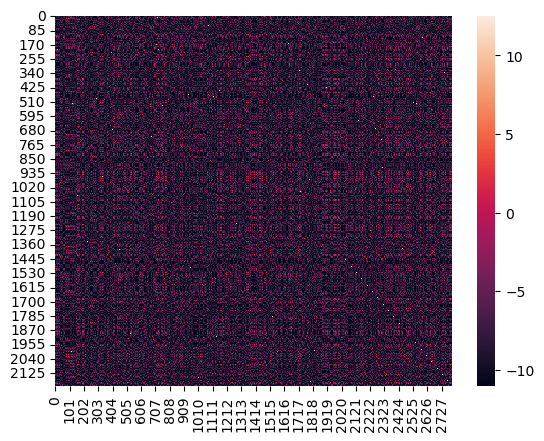

In [38]:
import seaborn as sns
sns.heatmap( np.array(w1).reshape(file_B.shape[0], file_A.shape[0]) )

In [31]:
np.array(w1).reshape(file_B.shape[0], file_A.shape[0])[:,3]

array([-11.01928978,  -6.29465713,  -8.07611833, ...,  -8.07611833,
        -8.07611833,  -8.07611833])

<AxesSubplot:>

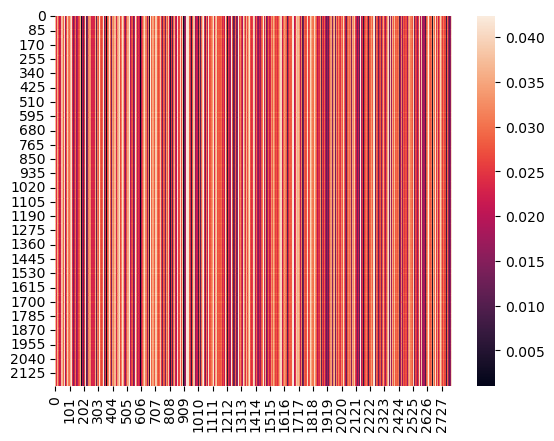

In [41]:
sns.heatmap( np.array(w2_matched_outcome).reshape(file_B.shape[0], file_A.shape[0]) )

<AxesSubplot:>

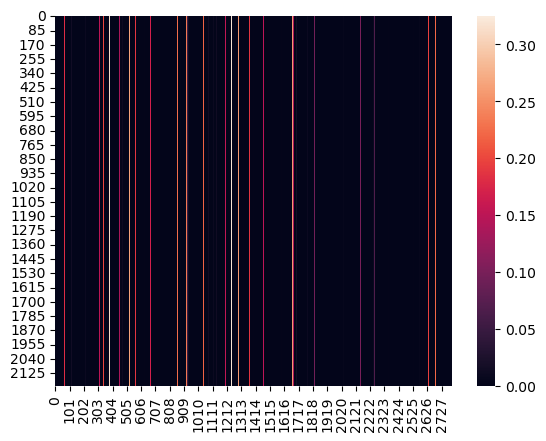

In [40]:
sns.heatmap( np.array(w2_unmatched_outcome).reshape(file_B.shape[0], file_A.shape[0]) )

<AxesSubplot:>

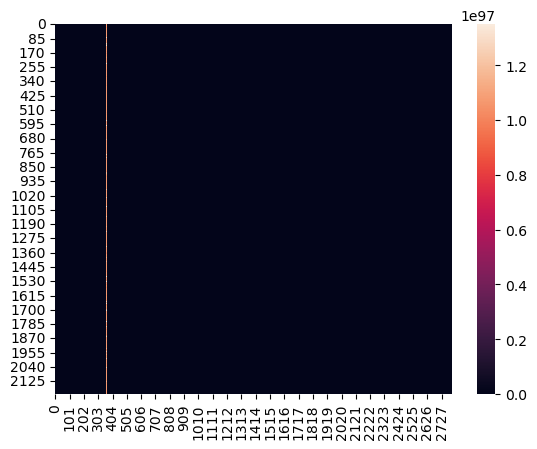

In [42]:
sns.heatmap( np.array(w2_matched_outcome/w2_unmatched_outcome).reshape(file_B.shape[0], file_A.shape[0]) )

<AxesSubplot:>

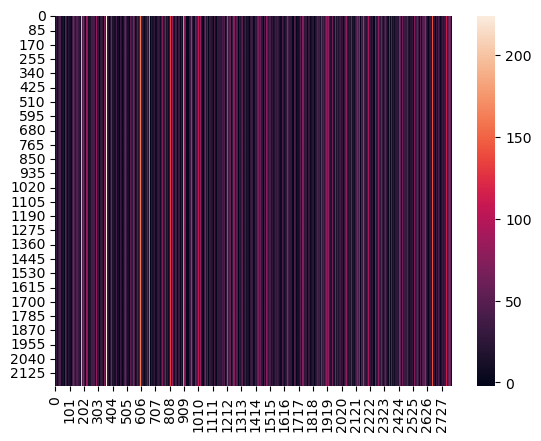

In [39]:
sns.heatmap( np.array(w2).reshape(file_B.shape[0], file_A.shape[0]) )

In [32]:
np.array(w2).reshape(file_B.shape[0], file_A.shape[0])[:,3]

array([36.95105161, 36.94758677, 36.94811458, ..., 36.95107032,
       36.94848051, 36.94524944])

In [37]:
np.exp(np.array(w1).reshape(file_B.shape[0], file_A.shape[0])[:,3] + np.array(w2).reshape(file_B.shape[0], file_A.shape[0])[:,3])

array([1.82818891e+11, 2.05304373e+13, 3.45898479e+12, ...,
       3.46922378e+12, 3.46025074e+12, 3.44908850e+12])

In [22]:
probabilities[:,3].argmax()

99

In [23]:
probabilities[:,3].max()

2.943504846742534e+21

In [26]:
A.iloc[3,:]

family_name                Tyran
was_assigned_female            0
country                       SI
birth_year                  1999
Y                     -10.462062
Name: 3, dtype: object

In [27]:
B.iloc[99,:]

name                       Ivan
family_name               Tyran
country                      SI
birth_year                 1999
was_assigned_female           0
X1                           21
X2                     1.463674
X3                    -0.504706
X4                       1.9645
X5                     0.449329
treatment                     0
Name: 99, dtype: object

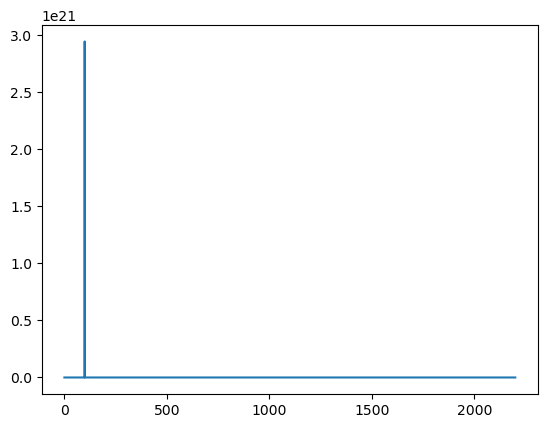

[3681.8474359]


In [21]:
plt.plot(probabilities[:,3])
plt.show()
print(proba_no_link[3])

In [ ]:
for fixed_j in range(file_B.shape[0]):
    proba_vector = probabilities[fixed_j,:]
    choice_array = list(filter(lambda x: x not in already_taken, np.arange(file_A.shape[0])))
    proba_vector = proba_vector[choice_array]
    choice_array = np.append(choice_array, -1)
    proba_vector = np.append(proba_vector, proba_no_link[fixed_j,:])
    proba_vector = proba_vector / proba_vector.sum()
    val = np.random.choice(choice_array, p = proba_vector)
    if val != -1:
        already_taken.append(val)
    new_z.append(val)

In [17]:
print(theta_m_k[-1])

print(theta_u_k[-1])

print(alpha_pi_k[-1])
print(beta_pi_k[-1])

print(a_sigma_k[-1])
print(b_sigma_k [-1])

print(a_sigma2_k[-1])
print(b_sigma2_k[-1])

print(beta0_k[-1])
print(beta1_k[-1])
print(alpha_k[-1])
print(sigma_square_k[-1])

print(mu2_k[-1])
print(sigma2_square_k[-1])

[0.99873455 0.99956525 0.99959027 0.99940868]
[0.66168638 0.80117363 0.43286567 0.00318228]
1
1
1
1
1
1
-9.497101381711605
1.4322528620598958
13.289001984282041
49483.49611546868
-7.537752742086302
71006.78338480605


In [15]:
z_k = [z0.copy()]
linked_records_k = [linked_records.copy()]

theta_m_k = [match.copy()]
theta_u_k = [unmatch.copy()]

a_sigma2_k = [1]
b_sigma2_k = [1]

mu2_k = [scipy.stats.norm.rvs(0,1)]
sigma2_square_k = [scipy.stats.invgauss.rvs(a_sigma2_k[-1],b_sigma2_k[-1])]

a_sigma_k = [1]
b_sigma_k = [1]

beta0_k = [scipy.stats.norm.rvs(0,1)]
beta1_k = [scipy.stats.norm.rvs(0,1)]
alpha_k = [scipy.stats.norm.rvs(0,1)]
sigma_square_k = [scipy.stats.invgauss.rvs(a_sigma_k[-1],b_sigma_k[-1])]

alpha_pi_k = [1]
beta_pi_k = [1]

for _ in tqdm.tqdm(range(100)):
    
    # new_theta_m, new_theta_u = update_linkage_param(AB, z_k[-1])
    # theta_m_k.append(new_theta_m)
    # theta_u_k.append(new_theta_u)

    # new_mu2, new_sigma2_square = update_unmatched_outcome_param(A, z_k[-1], mu2_k[-1], sigma2_square_k[-1], a_sigma2_k[-1], b_sigma2_k[-1])
    # mu2_k.append(new_mu2)
    # sigma2_square_k.append(new_sigma2_square)

    # new_beta0, new_beta1, new_alpha, new_sigma_square = update_matched_outcome_param(AB, z_k[-1], linked_records_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], sigma_square_k[-1], a_sigma_k[-1], b_sigma_k[-1])
    # beta0_k.append(new_beta0)
    # beta1_k.append(new_beta1)
    # alpha_k.append(new_alpha)
    # sigma_square_k.append(new_sigma_square)

    new_z = update_linkage_variable(AB, comparison_vectors_only, A, B, z_k[-1], theta_m_k[-1], theta_u_k[-1], mu2_k[-1], sigma2_square_k[-1], beta0_k[-1], beta1_k[-1], alpha_k[-1], alpha_pi_k[-1], beta_pi_k[-1], covariates)
    z_k.append(new_z)
    #linked_records_k.append(new_linked_records)

  6%|▌         | 6/100 [04:23<1:08:45, 43.89s/it]


KeyboardInterrupt: 

In [16]:
for _ in range(len(z_k)):
    print( (z_k[_] == true_linkage_z).sum() / len(true_linkage_z) )

0.5127272727272727
0.07454545454545454
0.08272727272727273
0.08454545454545455
0.085
0.0809090909090909
0.085


In [30]:
list(z_k[-1])

[37,
 1409,
 215,
 291,
 2446,
 2232,
 499,
 114,
 1312,
 550,
 2558,
 2270,
 1615,
 1228,
 147,
 569,
 1830,
 149,
 2668,
 1668,
 1054,
 1405,
 288,
 2415,
 1116,
 1513,
 1141,
 17,
 2216,
 154,
 314,
 68,
 1961,
 977,
 1869,
 2692,
 2382,
 2390,
 186,
 2166,
 1820,
 110,
 652,
 583,
 1501,
 2252,
 2601,
 984,
 609,
 2199,
 1357,
 1958,
 58,
 955,
 380,
 871,
 39,
 1146,
 1459,
 290,
 1562,
 1658,
 2530,
 1408,
 2654,
 2326,
 2768,
 1912,
 1999,
 2666,
 390,
 2780,
 1885,
 625,
 2510,
 567,
 1351,
 251,
 774,
 1586,
 820,
 1121,
 2242,
 1487,
 461,
 2250,
 2676,
 2267,
 1648,
 2544,
 1498,
 1197,
 985,
 2291,
 83,
 102,
 2135,
 297,
 2704,
 2044,
 403,
 2626,
 1163,
 2126,
 2152,
 526,
 1047,
 1218,
 2732,
 2771,
 996,
 2490,
 1120,
 1499,
 2041,
 1713,
 2542,
 2343,
 65,
 1452,
 1001,
 391,
 20,
 507,
 1537,
 1415,
 96,
 1663,
 2385,
 187,
 366,
 1500,
 837,
 2554,
 629,
 895,
 1086,
 501,
 1025,
 60,
 761,
 2165,
 1100,
 770,
 1119,
 1703,
 930,
 2470,
 1980,
 1709,
 1831,
 197,
 15

In [28]:
list(true_linkage_z)

[-1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,